Домашняя работа к лекции 6 по курсу Машинное обучение.
---------
**Ансамблирование**

Студента: **Помойницкого Евгения**

Группа: **DS 8**

**Домашнее задание по теме «Ансамблирование»**

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline

In [83]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [84]:
df.shape

(1460, 81)

Произведем обработку данных:
1. Выделим категориальные признаки;
2. Заменим отстутсвующие значения категориальных признаков строковым значением;
3. Заменим отсутствующие значения чиловых признаков специальным значением. Для его определения небходимо будет посмотреть границы значений признаков, где есть отсутствующие значения;
4. Переведем категориальные признаки в дамми;

ВЫделим категориальные признаки и заменим отстутствующие значения строковым значением 'nan'

In [85]:
categ = list(df.dtypes[df.dtypes == object].index)
categ

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [86]:
df[categ] = df[categ].fillna('nan')

Выделим числовые признаки, отделим те, у которых встречаются отсутствующие значения и посмотрим границы значений признаков. Это позволит подобрать такое искусственное значение, которое не входит в область реальных значений.

In [87]:
numer = [d for d in df if d not in df[categ]]
numer

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [88]:
a = dict(df[numer].isna().sum())

In [89]:
num_na_list = [key for key, value in a.items() if value > 0]
num_na_list

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [90]:
df[num_na_list].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


Мы видим, что значения трех признаков у которых встречаются отстутствующие значения, неотрицательные. Тогда возьмем подходящее отрицательное число и заменим им отстуствующие значения.
Финально, заменим категориальные признаки dummy значениями и соберем обработанный датасет.

In [91]:
df_dummy = pd.get_dummies(df[categ], columns = categ)

In [92]:
data = pd.concat([df[numer].fillna(-99), df_dummy], axis=1)
data.shape

(1460, 306)

In [93]:
y = data['SalePrice']
y.shape

(1460,)

In [94]:
x_col = [i for i in data if i != 'SalePrice']
len(x_col)

305

In [95]:
X = data[x_col]
X.shape

(1460, 305)

In [96]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Случайный лес
---

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [98]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [99]:
rf.fit(X_train, y_train).score(X_test, y_test)

0.8467885543373723

In [100]:
y_pred = rf.predict(X_test)

print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.8467885543373723
RMSE: 	 34509.39582846884
MAE: 	 19331.959965753427


In [101]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [102]:
y_pred = rf.predict(X_test)

print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.8385980182881734
RMSE: 	 35419.80632102337
MAE: 	 20429.51404109589


Выведем важность признаков

In [103]:
imp = pd.Series(rf.feature_importances_)
imp.sort_values(ascending=False)

4      0.582594
16     0.109963
19     0.035869
12     0.030658
9      0.024978
         ...   
128    0.000000
250    0.000000
55     0.000000
276    0.000000
56     0.000000
Length: 305, dtype: float64

In [104]:
len([x for x in imp if x!=0])

288

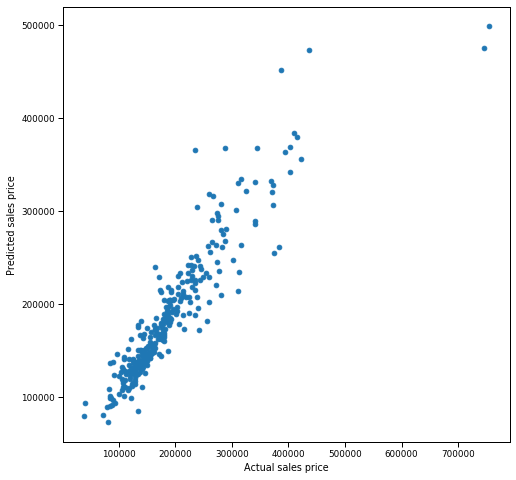

In [105]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual sales price')
plt.ylabel('Predicted sales price')

plt.show()

[]

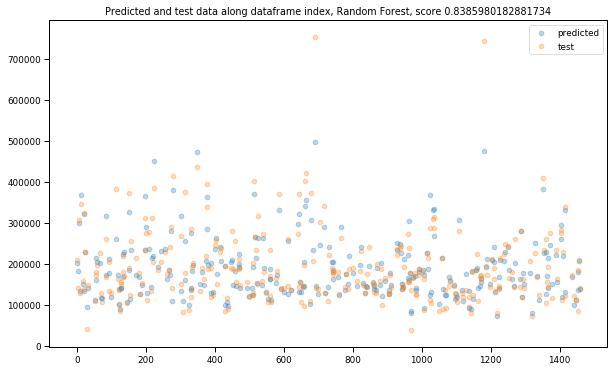

In [107]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_pred, alpha=0.3, label='predicted')
plt.scatter(X_test.index, y_test, alpha=0.3, label='test')
plt.title('Predicted and test data along dataframe index, Random Forest, score {}'.format(r2_score(y_test, y_pred)))
plt.legend()
plt.plot()

Видим, что случайный лес в основном использовал два признака, остальные - в малой степени, несколько - не учитывал. Также, видим, что для достижения тех же результатов, в данной задаче можно использовать меньше деревьев, чем по умолчанию. Из визуальных отображений можно сделать несколько выводов:
- данные использовались равномерно на всей длине, то есть обработка данных обеспечила адекватное качество для модели;
- чем выше цена, тем хуже предсказание случайного леса. 

Стекинг
---

В качестве моделей для стекинга возьмем: логистическую регрессию, линейную регрессию, kNN.

Случайный лес работал без нормировки данных. Но для работы других моделей необходимо отнормировать данные. ВЫполним нормировку Мин-Макс.

In [113]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

In [114]:
scaler = MinMaxScaler(copy=False)

In [115]:
col = df[numer].columns
col = [x for x in col if x!='SalePrice']

In [116]:
df_norm = scaler.fit_transform(df[col].fillna(-99))

In [117]:
df_norm

array([[0.00000000e+00, 2.35294118e-01, 3.98058252e-01, ...,
        0.00000000e+00, 9.09090909e-02, 5.00000000e-01],
       [6.85400960e-04, 0.00000000e+00, 4.34466019e-01, ...,
        0.00000000e+00, 3.63636364e-01, 2.50000000e-01],
       [1.37080192e-03, 2.35294118e-01, 4.05339806e-01, ...,
        0.00000000e+00, 7.27272727e-01, 5.00000000e-01],
       ...,
       [9.98629198e-01, 2.94117647e-01, 4.00485437e-01, ...,
        1.61290323e-01, 3.63636364e-01, 1.00000000e+00],
       [9.99314599e-01, 0.00000000e+00, 4.05339806e-01, ...,
        0.00000000e+00, 2.72727273e-01, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 4.22330097e-01, ...,
        0.00000000e+00, 4.54545455e-01, 5.00000000e-01]])

In [119]:
df_norm = pd.DataFrame(df_norm)
df_norm.columns = list(col)
df_norm

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.000000,0.235294,0.398058,0.033420,0.666667,0.500,0.949275,0.883333,0.173632,0.125089,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.00000,0.090909,0.50
1,0.000685,0.000000,0.434466,0.038795,0.555556,0.875,0.753623,0.433333,0.058270,0.173281,...,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.363636,0.25
2,0.001371,0.235294,0.405340,0.046507,0.666667,0.500,0.934783,0.866667,0.153620,0.086109,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.00000,0.727273,0.50
3,0.002056,0.294118,0.385922,0.038561,0.666667,0.500,0.311594,0.333333,0.058270,0.038271,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.00000,0.090909,0.00
4,0.002742,0.235294,0.444175,0.060576,0.777778,0.500,0.927536,0.833333,0.264273,0.116052,...,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.00000,1.000000,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.997258,0.235294,0.390777,0.030929,0.555556,0.500,0.920290,0.833333,0.058270,0.000000,...,0.324401,0.000000,0.073126,0.000000,0.0,0.0,0.0,0.00000,0.636364,0.25
1456,0.997944,0.000000,0.446602,0.055505,0.555556,0.625,0.768116,0.633333,0.128311,0.139972,...,0.352609,0.407235,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.090909,1.00
1457,0.998629,0.294118,0.400485,0.036187,0.666667,1.000,0.500000,0.933333,0.058270,0.048724,...,0.177715,0.000000,0.109689,0.000000,0.0,0.0,0.0,0.16129,0.363636,1.00
1458,0.999315,0.000000,0.405340,0.039342,0.444444,0.625,0.565217,0.766667,0.058270,0.008682,...,0.169252,0.427071,0.000000,0.202899,0.0,0.0,0.0,0.00000,0.272727,1.00


In [120]:
data2 = pd.concat([df_norm, df_dummy], axis=1)
data2.shape

(1460, 305)

In [121]:
y = df['SalePrice']
y.shape

(1460,)

In [122]:
X = data2
X.shape

(1460, 305)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Проверим, как работают в стекинге базовые регрессоры

In [124]:
estimators = [
    ('rf', RandomForestRegressor()),
    ('lin_r', LinearRegression()),
    ('knn', KNeighborsRegressor())
]

In [125]:
regr = StackingRegressor(estimators=estimators)

In [126]:
regr.fit(X_train, y_train).score(X_test, y_test)

-8.254529527132272e+27

Результат не самый ожидаемый, настолько плохое качество предсказания было неочевидно. Проверим работу стекинга на других регрессорах, возьмем те, что используются для примера в документации.

In [127]:
estimators2 = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42)),
    ('rf', RandomForestRegressor())
]

In [128]:
regr = StackingRegressor(estimators=estimators2)

In [129]:
regr.fit(X_train, y_train).score(X_test, y_test)

0.848115948532699

In [130]:
y_pred = regr.predict(X_test)

print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.848115948532699
RMSE: 	 34359.57927715522
MAE: 	 20285.82298883494


[]

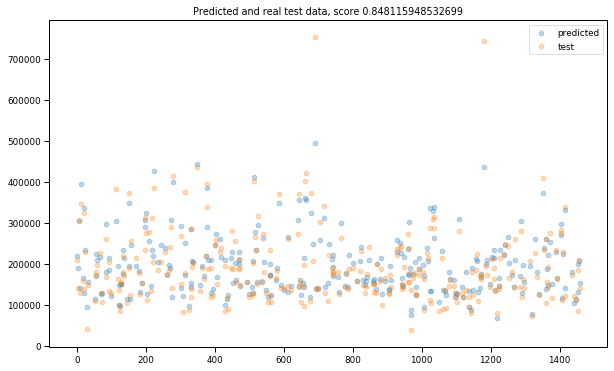

In [132]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_pred, alpha=0.3, label='predicted')
plt.scatter(X_test.index, y_test, alpha=0.3, label='test')
plt.title('Predicted and real test data, score {}'.format(r2_score(y_test, y_pred)))
plt.legend()
plt.plot()

Проверим, повлияет ли на точность предсказания увеличение количества деревьев в алгоритме, выполняющем стекинг.

In [133]:
regr = StackingRegressor(estimators=estimators2, 
                         final_estimator=RandomForestRegressor(n_estimators=10, random_state=42), 
                         cv=10)

In [134]:
regr.fit(X_train, y_train).score(X_test,y_test)

0.8129331635138556

In [135]:
y_pred = regr.predict(X_test)

[]

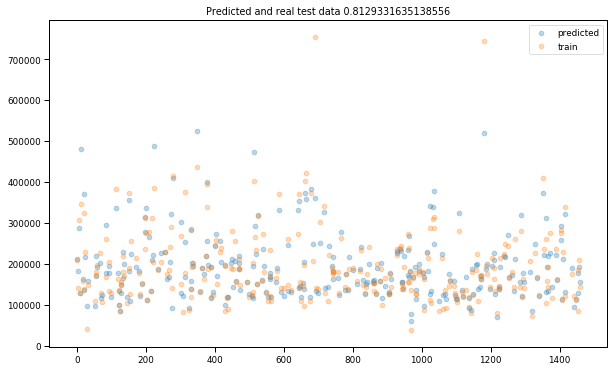

In [136]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_pred, alpha=0.3, label='predicted')
plt.scatter(X_test.index, y_test, alpha=0.3, label='train')
plt.title('Predicted and real test data {}'.format(r2_score(y_test, y_pred)))
plt.legend()
plt.plot()

Видно, что вдоль выборки данных выбраны без видимых аномалий и пробелов, то есть обработка данных обеспечила необходимое качество для моделей. При этом наилучшее совпадение предсказанных и реальных значений находится в диапазоне цены 100000 - 200000

Как мы видим, с применением регрессоров  стекинг может дать точность на несколько процентов выше, чем случайный лес. Но при этом, результат сильно зависит от комбинации оценивающих моделей и взвешивающей модели. На наших данных взвешивающая модель по умолчанию - RidgeCV, дала более качественный результат, чем RandomForest.

In [137]:
import seaborn as sns

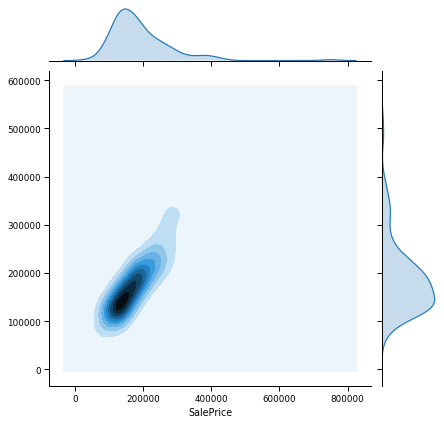

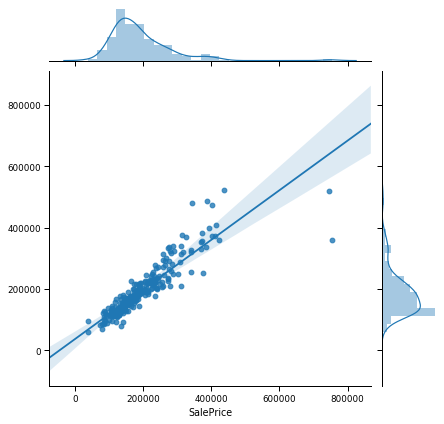

In [138]:
sns.jointplot(x=y_test, y=y_pred, kind='kde')
sns.jointplot(y_test, y_pred, kind='reg')

plt.show()

Визуально интерпретируя графики, можно сделать вывод, что модель с более высокой точностью предсказывает "массовый сегмент" с ценой в лимитах 100000 - 200000.